# Generación sintética de cascadas hadrónicas usando Redes Generativas Antagónicas con datos del Observatorio HAWC

## Posgrado en Ciencia e Ingeniería de la Computación

### Murrieta León Juan Eduardo

---------------------------------------


En este trabajo se implementa un Generador de cascadas hadrónicas sintéticas a partir de mapas de calor que representan las mediciones de energía de los múltiples detectores PMT que componen el observatorio.

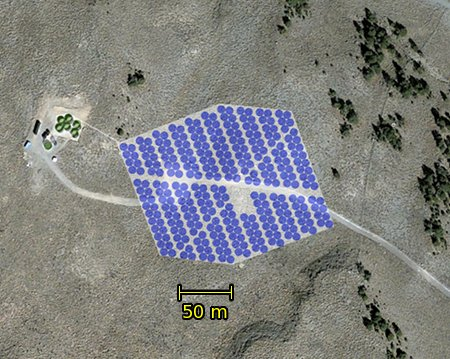

Para ello se implementa una Red Generativa Adversarial que se entrena con imagenes creadas a partir de los histogramas de energía de cada detector en un cierto período de tiempo.
La idea original viene del artículo: Prototyoe Open Event Reconstruction Pipeline for the Cherenkov Telescope Array (https://astro.paperswithcode.com/paper/prototype-open-event-reconstruction-pipeline). En el que se implementa una biblioteca en python para procesar los datos de un observatorio Cherenkov de un tipo diferente a HAWC, no obstante no se utilizó el código ahí implementado ya que son sistemas diferentes. En su lugar se empleo un modelo de una red Generativa modificado para el propósito de este trabajo.

Ref: https://realpython.com/generative-adversarial-networks/

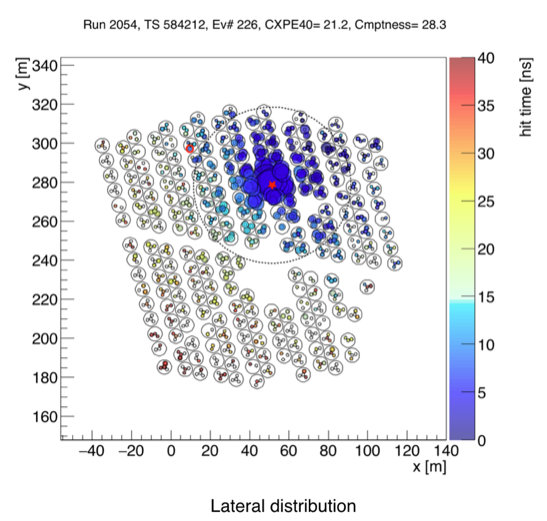

Implementación de una red generativa antagónica GAN para la generación sintética de simulaciones de los detectores de HAWC.

In [18]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

In [19]:
import pandas as pd
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
from random import randrange
import copy
import random

In [20]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [21]:
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# por reproducibilidad
set_seed()

Los datos para el entrenamiento se encuentran en el directorio HAWC/hadron, en este caso se usa Google Drive para guardar la información.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


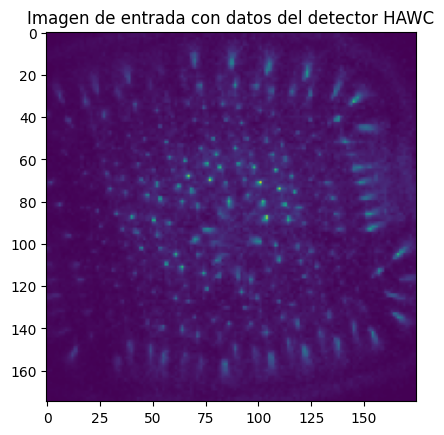

Image Size (175, 175, 4) 122500


In [47]:
hadrons='/content/drive/MyDrive/Colab Notebooks/HAWC/hawc_events/hadron/'
detector_data=os.listdir(hadrons)
img = mpimg.imread(hadrons+detector_data[6])
plt.imshow(img)
plt.title("Imagen de entrada con datos del detector HAWC")
plt.show()
print(f'Image Size {img.shape}',img.size)

Por limitaciones de memoria la imgagen es reescalada a un formato de 150x150 pixeles, en tonos de gris y normalizada entre -1 y 1.

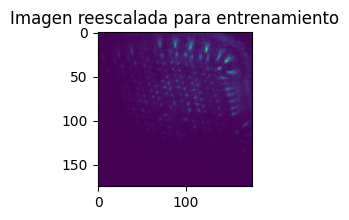

In [24]:
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title("Imagen reescalada para entrenamiento")
plt.show()

Transformaciones de la imagen para el entrenamiento.

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Grayscale(),transforms.Resize(size=[150,150],antialias=True),transforms.Normalize((0.5,), (0.5,))]
)

In [26]:
train_set=torchvision.datasets.ImageFolder('/content/drive/MyDrive/Colab Notebooks/HAWC/hawc_events/',transform=transform)


Definimos el lote de trabajo.

In [27]:
batch_size = 2
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

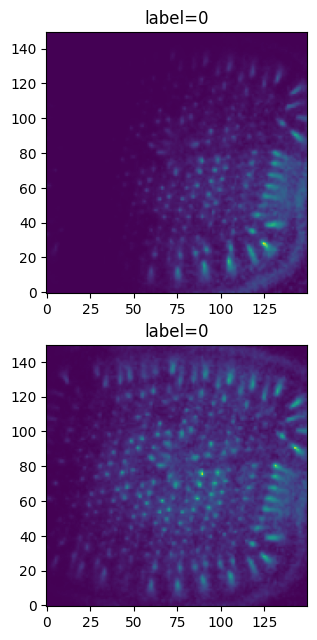

In [40]:
fig = plt.figure(figsize=(8, 40))
for images, labels in train_loader:

    for i in range(batch_size%10):
        map=images[i,0].numpy()
        fig.add_subplot(10, 1, i+1)
        #plt.imshow(map[idx,0]-map[0,0],  origin='lower')
        plt.imshow(map,  origin='lower')
        plt.title(f'label={labels[i]}')
        img=map
    break

Definición del Discriminador:


*   Capa Lineal de 22500 (150x150) -> 11250
**   Función de activación ReLU
**   Dropout del 0.5%
*   Capa Lineal de 11250 -> 512
**  Función de activación ReLU
**  Dropout del 0.3%
*   Capa Lineal 512 -> 256
**  Función de activación ReLU
**  Dropout del 0.1 %
*   Capa de salida de 256->1
**  Función de activación Sigmoide



In [29]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(22500, 11250), #nn.Linear(22500, 768),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(11250, 512), #nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 22500)
        output = self.model(x)
        return output

In [30]:
discriminator = Discriminator().to(device=device)
best_discriminator = copy.deepcopy(discriminator)

Definición del Generador:

*   Capa Lineal de 100 -> 256
**   Función de activación ReLU
*   Capa Lineal de 256 -> 512
**  Función de activación ReLU
*   Capa Lineal 512 -> 2048
**  Función de activación ReLU
*   Capa Lineal 2048 -> 11250
**  Función de activación ReLU
*   Capa de salida de 11250 -> 22500
**  Función de activación Tanh



In [31]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2048), #nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(2048, 11250), #nn.Linear(512, 768),
            nn.ReLU(),
            nn.Linear(11250, 22500), #nn.Linear(768, 22500),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 150, 150)
        return output

generator = Generator().to(device=device)
best_generator = copy.deepcopy(generator)

Parámetros del entrenamiento:
* Tasa de aprendizaje: 0.00001
* Número de épocas: 15
* Función de pérdida: Entropía binaria cruzada BCELoss.

In [32]:
lr = 0.00001
num_epochs = 15
loss_function = nn.BCELoss()

Optimizador del gradiente: Adam.

In [33]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

Ciclo de entrenamiento de la GAN

In [34]:
for epoch in range(num_epochs):
    best_loss_discriminator=10000
    best_loss_generator=10000
    for n, (real_samples, labels) in enumerate(train_loader):

        # Datos de entrenamiento para el discriminador
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )

        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Entrenamiento del discriminador
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        #print(output_discriminator.shape)
        if output_discriminator.shape[0] != batch_size*2:
            print('skip!')
            continue

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Datos para entrenamiento del Generador
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Entrenamiento del Generador
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        if best_loss_discriminator>loss_discriminator:
           best_loss_discriminator=loss_discriminator
           best_discriminator = copy.deepcopy(discriminator)
        if best_loss_generator>loss_generator:
           best_loss_generator=loss_generator
           best_generator = copy.deepcopy(generator)

        # Valor de pérdida de ambas redes
        if n == batch_size - 1:
          print(f"Epoch: {epoch} Loss Discriminador: {loss_discriminator}")
          print(f"Epoch: {epoch} Loss Generador: {loss_generator}")

Epoch: 0 Loss Discriminador: 0.6770099401473999
Epoch: 0 Loss Generador: 0.7186890840530396
Epoch: 1 Loss Discriminador: 0.4669054448604584
Epoch: 1 Loss Generador: 0.6062076091766357
Epoch: 2 Loss Discriminador: 0.43370360136032104
Epoch: 2 Loss Generador: 0.681646466255188
Epoch: 3 Loss Discriminador: 0.536736011505127
Epoch: 3 Loss Generador: 1.3500103950500488
Epoch: 4 Loss Discriminador: 0.9883595108985901
Epoch: 4 Loss Generador: 0.7885932922363281
Epoch: 5 Loss Discriminador: 0.9771460294723511
Epoch: 5 Loss Generador: 0.5787993669509888
Epoch: 6 Loss Discriminador: 0.6940351724624634
Epoch: 6 Loss Generador: 0.5118732452392578
Epoch: 7 Loss Discriminador: 0.5708198547363281
Epoch: 7 Loss Generador: 0.8295941352844238
Epoch: 8 Loss Discriminador: 0.9788373708724976
Epoch: 8 Loss Generador: 0.5671049952507019
Epoch: 9 Loss Discriminador: 0.7632217407226562
Epoch: 9 Loss Generador: 0.8184942007064819
Epoch: 10 Loss Discriminador: 0.6805674433708191
Epoch: 10 Loss Generador: 0.7712

Generamos una secuencia aleatoria de entrada explorar el espacio latente del generador.

In [49]:
latent_space_samples = torch.randn(256,100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
generated_samples = generated_samples.to(device='cpu')
print(f'generated_samples.shape={generated_samples.shape}')
map=generated_samples.numpy()

generated_samples.shape=torch.Size([256, 1, 150, 150])


Visualizamos la imagen generada.

img.shape=torch.Size([256, 100])


Text(0.5, 1.0, 'Muestra detector')

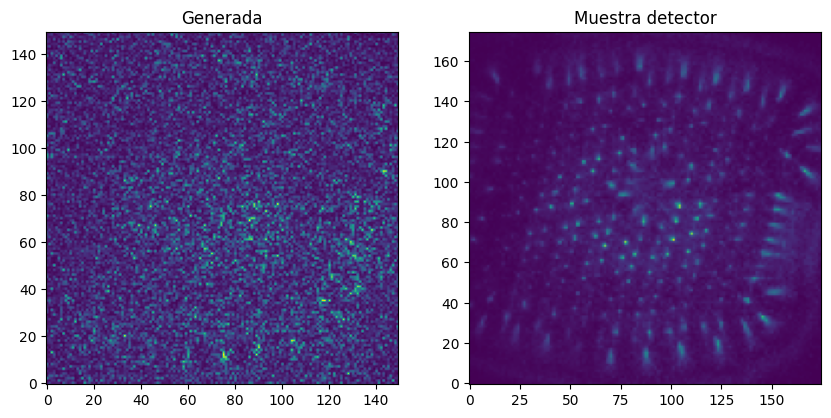

In [50]:
fig = plt.figure(figsize=(10, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(map[randrange(256),0],  origin='lower')
plt.title("Generada")
fig.add_subplot(1, 2, 2)
print(f'img.shape={latent_space_samples.shape}')
plt.imshow(img,origin='lower')
plt.title("Muestra detector")

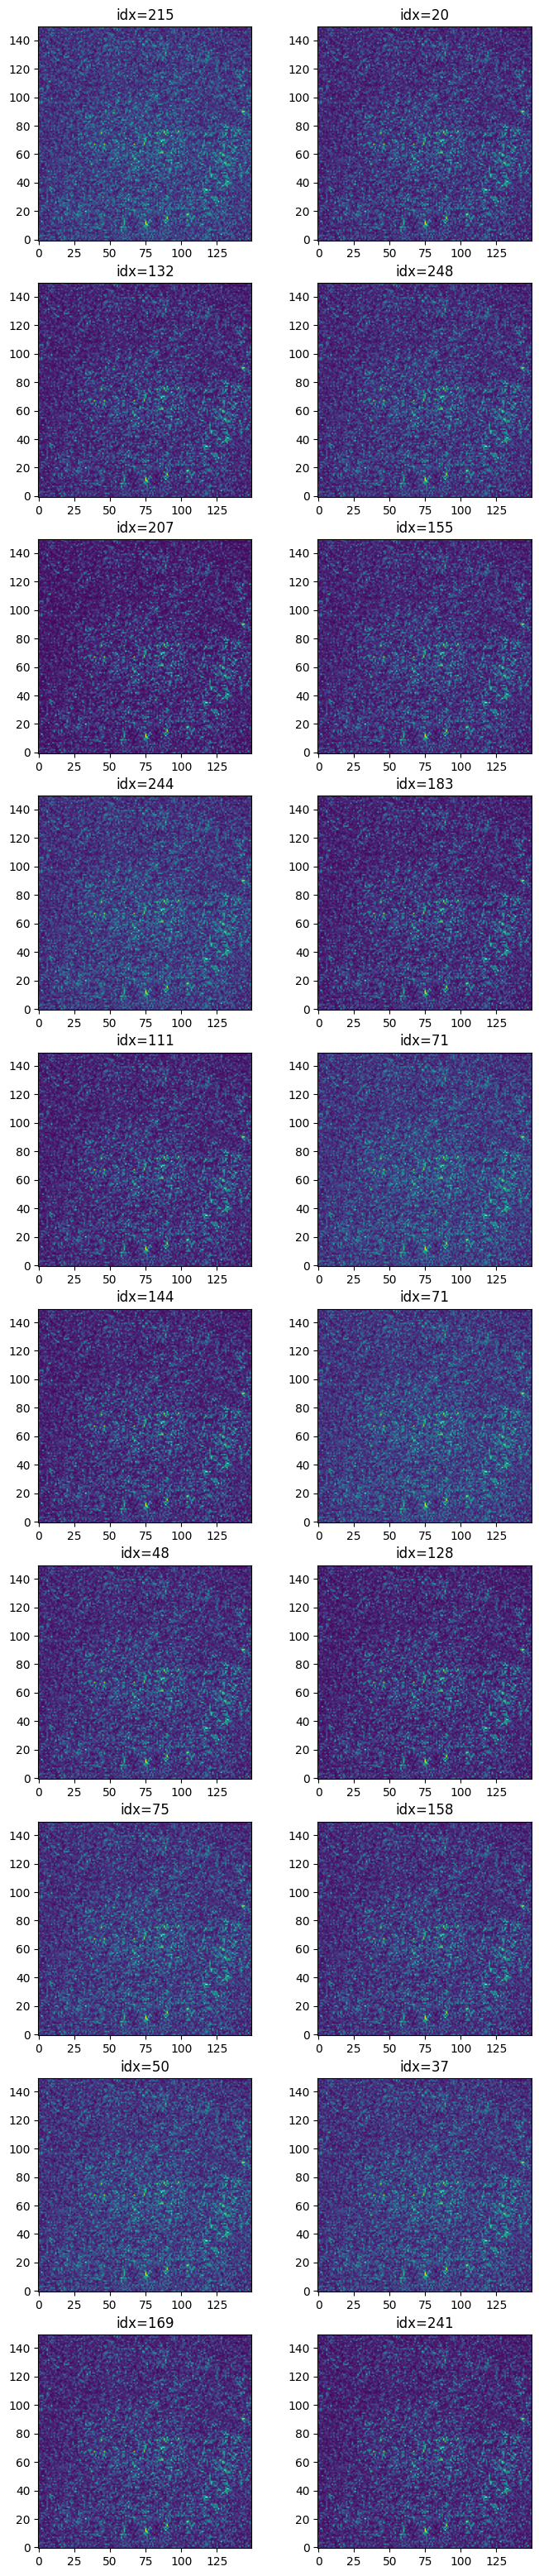

In [37]:
fig = plt.figure(figsize=(8, 5*20))
for i in range(10):
  for j in range(2):
    idx=randrange(256)
    fig.add_subplot(25, 2, i*2+j+1)
    #plt.imshow(map[idx,0]-map[0,0],  origin='lower')
    plt.imshow(map[idx,0],  origin='lower')
    plt.title(f'idx={idx}')
